### Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import pickle
import joblib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)

### Reading Data from CSV

In [ ]:
df = pd.read_csv('/content/Bengaluru_House_Data.csv')

### Basic Inspection

In [ ]:
df.shape

(13320, 9)

In [ ]:
df.head(5)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13320 entries, 0 to 13319
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   area_type     13320 non-null  object 
 1   availability  13320 non-null  object 
 2   location      13319 non-null  object 
 3   size          13304 non-null  object 
 4   society       7818 non-null   object 
 5   total_sqft    13320 non-null  object 
 6   bath          13247 non-null  float64
 7   balcony       12711 non-null  float64
 8   price         13320 non-null  float64
dtypes: float64(3), object(6)
memory usage: 936.7+ KB


In [ ]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


### Column: bath (No. of bathrooms)

    Mean: 2.69 → most homes have 2–3 bathrooms on average.
    Std (1.34): moderate spread — most properties are between 1 and 4 baths.
    Min = 1 → all properties have at least 1 bathroom.
    Max = 40 → unrealistic! This is likely a data entry error or outlier.

### Column: balcony (No. of balconies)
    Mean = 1.58 → most homes have 1–2 balconies.
    Std = 0.82 → small variation, which makes sense.
    Min = 0 → some homes have no balcony (common in small flats).
    Max = 3 → looks reasonable; very few homes have more than 3 balconies.
    This variable has low variance, so its predictive power may be limited.

### Column: price (in lakhs)
    Mean = 112.56 → average property costs ~1.1 crore.
    Std = 148.97 → huge variation, indicating a wide price range.
    Min = 8 → cheapest property is 8 lakhs.
    25% = 50, 50% = 72, 75% = 120 →
    25% of homes cost ≤ 50 lakhs
    Median price = 72 lakhs
    75% of homes cost ≤ 1.2 crore
    Max = 3600 → 36 crore property — likely a luxury villa, penthouse, or outlier. Needs verification.
    Price has a heavy right skew (long tail with ultra-expensive properties).

### Data Quality Checks

In [ ]:
df.isnull().sum()

,0
area_type,0
availability,0
location,1
size,16
society,5502
total_sqft,0
bath,73
balcony,609
price,0


In [ ]:
'''
Extracting coulmns with missing values
take each column (feature) in the dataset, loop through all columns of the dataframe, and checks if column has > 0 missing values
'''
missing_val_col = [features for features in df.columns if df[features].isnull().sum() > 0]
missing_val_col

['location', 'size', 'society', 'bath', 'balcony']

In [ ]:
### Calculating missing %
for col in missing_val_col:   # taking column from missing columns we extracted
  missing_count = df[col].isnull().sum()   # counting no.of nulls in column
  total_count = len(df[col])           # calculating length
  missing_percent = (missing_count / total_count) * 100     # calcultaing missing%
  print(f"{col} : {missing_percent:.2f}% missing")

location : 0.01% missing
size : 0.12% missing
society : 41.31% missing
bath : 0.55% missing
balcony : 4.57% missing


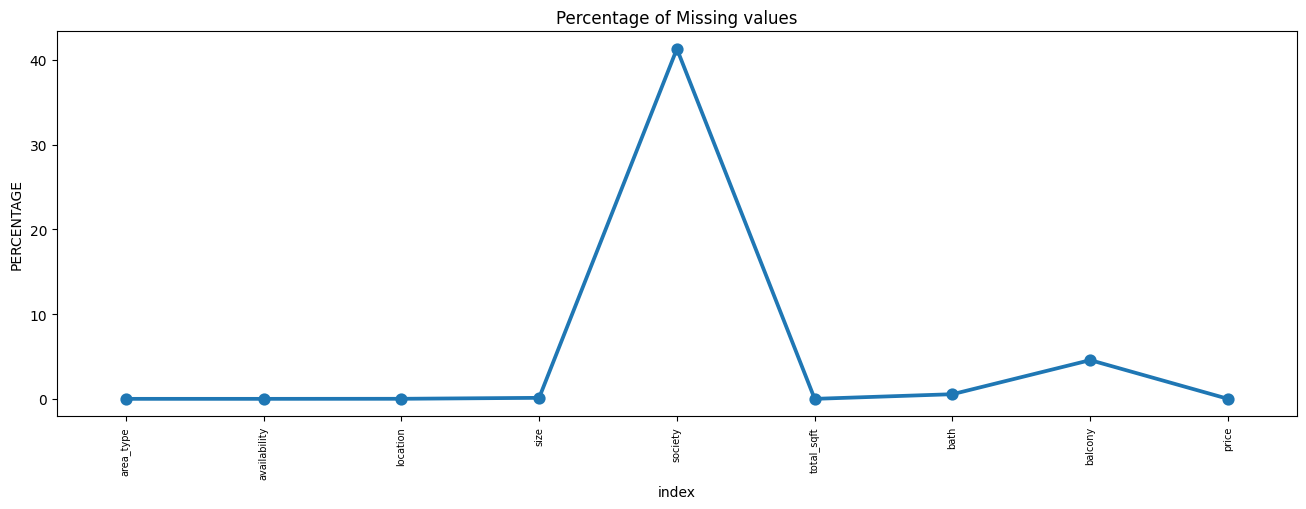

In [ ]:
### Graphical representation of missing values
missing = pd.DataFrame((df.isnull().sum())*100/df.shape[0]).reset_index()
plt.figure(figsize=(16,5))
ax = sns.pointplot(x='index',y=0,data=missing)
plt.xticks(rotation =90,fontsize =7)
plt.title("Percentage of Missing values")
plt.ylabel("PERCENTAGE")
plt.show()

**location**, **size**, **society**, **bath**, **balcony** are the columns with misisng values.

**society** column have more than 41% missing values.

📌 Final Recommendations

    Drop: Missing rows for location (tiny %).

    Median Imputation: Size, Bath.

    Mode / Derived Feature: Balcony.

    Special Handling: Society → Unknown category, then check feature importance.

In [ ]:
### Creating copy of the dataset
df_copy = df.copy()

In [ ]:
### Drop: Missing rows for location (tiny %).
df_copy = df_copy.dropna(subset=['location'])

In [ ]:
df_copy.isnull().sum()

,0
area_type,0
availability,0
location,0
size,16
society,5502
total_sqft,0
bath,73
balcony,609
price,0


In [ ]:
### getting unique values for column 'size'
df_copy['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', nan, '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

**size** column have **BHK** which stands for bedroom, hall, and kitchen, and **Bedroom** values.

In [ ]:
### Extracting integer part from size column to create new column
df_copy['bhk'] = df_copy['size'].apply(lambda x: int(str(x).split(' ')[0]) if pd.notnull(x) else None)

In [ ]:
df_copy.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price,bhk
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07,2.0
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00,4.0
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00,3.0
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00,3.0
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00,2.0


In [ ]:
df_copy.dtypes

,0
area_type,object
availability,object
location,object
size,object
society,object
total_sqft,object
bath,float64
balcony,float64
price,float64
bhk,float64


In [ ]:
### Dropping size column as we have created new column bhk
df_copy = df_copy.drop('size', axis=1)
df_copy.columns

Index(['area_type', 'availability', 'location', 'society', 'total_sqft',
       'bath', 'balcony', 'price', 'bhk'],
      dtype='object')

In [ ]:
df_copy['bhk'].unique()

array([ 2.,  4.,  3.,  6.,  1.,  8.,  7.,  5., 11.,  9., nan, 27., 10.,
       19., 16., 43., 14., 12., 13., 18.])

there are some unique values which doesn't look true, like house with 43 bedrooms.

In [ ]:
### Imputing size column with median size
df_copy['bhk'] = df_copy['bhk'].fillna(df_copy['bhk'].median())

In [ ]:
df_copy[df_copy['bhk'] > 20]

,area_type,availability,location,society,total_sqft,bath,balcony,price,bhk
1718,Super built-up Area,Ready To Move,2Electronic City Phase II,NaN,8000,27.0,0.0,230.0,27.0
4684,Plot Area,Ready To Move,Munnekollal,NaN,2400,40.0,0.0,660.0,43.0


so, house with area of 2400 sqft have 43 bedrooms, this looks like some kind of error.

And to look at this error we have to look at total_sqft column.

In [ ]:
### getting unique values from total_sqft column
sqft_unique = df_copy['total_sqft'].unique()
print(sqft_unique)

['1056' '2600' '1440' ... '1133 - 1384' '774' '4689']


total_sqft should be int or float but it is of object type, because we have some values who are not single values but ranges.

In [ ]:
### function to check if a value can be converted to float
def is_float(x):
  try:
    float(x)
  except:      # If conversion fails (raises an error), return False
    return False
  return True

In [ ]:
sqft_messy = df_copy[~df_copy['total_sqft'].apply(is_float)].head(30)
sqft_messy['total_sqft']

,total_sqft
30,2100 - 2850
56,3010 - 3410
81,2957 - 3450
122,3067 - 8156
137,1042 - 1105
165,1145 - 1340
188,1015 - 1540
224,1520 - 1740
410,34.46Sq. Meter
549,1195 - 1440


Here we will get the mean of the range, and convert the different units into square feet.

In [ ]:
### function to handle range values like "2100-2850"
def convert_range(value):
    try:
        parts = value.split('-')   # Split the string into two parts using '-'
        return (float(parts[0]) + float(parts[1])) / 2    # Convert both parts to float, take the average
    except:
        return None

In [ ]:
import re

In [ ]:
### Function to convert different area units into square feet (sqft)
def convert_to_sqft(value):
  try:
    if 'Sq. Meter' in value:
      num = float(re.findall(r"[\d.]+", value)[0])     # Extract the numeric part (e.g., "34.46Sq. Meter" → 34.46)
      return num * 10.7639     # Convert square meters to square feet
    elif 'Sq. Yards' in value:
      num = float(re.findall(r"[\d.]+", value)[0])
      return num * 9
    elif 'Acres' in value:
      num = float(re.findall(r"[\d.]+", value)[0])
      return num * 43560
    elif 'Perch' in value:
      return float(re.findall(r"[\d.]+", value)[0])  # Already in sqft
    elif '-' in value:
      return convert_range(value)
    else:
      return float(value)
  except:
    return None

In [ ]:
df_copy['total_sqft_cleaned'] = df_copy['total_sqft'].apply(convert_to_sqft)

In [ ]:
### Creating new column price_per_sqft
df_copy['price_per_sqft'] = df_copy['price']*100000 / df_copy['total_sqft_cleaned']

In [ ]:
df_copy.head(5)

,area_type,availability,location,society,total_sqft,bath,balcony,price,bhk,total_sqft_cleaned,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,Coomee,1056,2.0,1.0,39.07,2.0,1056.0,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,Theanmp,2600,5.0,3.0,120.00,4.0,2600.0,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,NaN,1440,2.0,3.0,62.00,3.0,1440.0,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,Soiewre,1521,3.0,1.0,95.00,3.0,1521.0,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,NaN,1200,2.0,1.0,51.00,2.0,1200.0,4250.000000


In [ ]:
df_copy['location'].nunique()

1305

Location have too many unique values, when we perform one hot encoding, this will become a dimensionality curse.

In [ ]:
### Striping any unneccary spaces from location column
df_copy['location'] = df_copy['location'].str.strip()

In [ ]:
location_count = df_copy.groupby('location')['location'].count().sort_values(ascending=False)
location_count[location_count <= 10].count()

np.int64(1053)

there 1053 locations out of 1305 where the location count is less than or equal to 10.

In [ ]:
### filtering locations where location count is less than or equal to 10
filtered_location = location_count[location_count <= 10]
filtered_location

,location
location,
Gunjur Palya,10
Sadashiva Nagar,10
Basapura,10
Dodsworth Layout,10
1st Block Koramangala,10
...,...
sapthagiri Layout,1
sarjapura main road,1
kamanahalli main road,1


In [ ]:
### converting locations with less than or equal to 10 count -> other, to reduce dimensions
df_copy['location'] = df_copy['location'].apply(lambda x: 'other' if x in filtered_location else x)

In [ ]:
df_copy['location'].nunique()

242

150 sqft is considered as standard room area. while the max value for area is 1500. We are going to drop these entries.

In [ ]:
### Extracting area per room in sqft for area < 150 sqft
df_copy = df_copy[~(df_copy['total_sqft_cleaned'] / df_copy['bhk'] < 150)]
df_copy.head(5)

,area_type,availability,location,society,total_sqft,bath,balcony,price,bhk,total_sqft_cleaned,price_per_sqft
0,Super built-up Area,19-Dec,Electronic City Phase II,Coomee,1056,2.0,1.0,39.07,2.0,1056.0,3699.810606
1,Plot Area,Ready To Move,Chikka Tirupathi,Theanmp,2600,5.0,3.0,120.00,4.0,2600.0,4615.384615
2,Built-up Area,Ready To Move,Uttarahalli,NaN,1440,2.0,3.0,62.00,3.0,1440.0,4305.555556
3,Super built-up Area,Ready To Move,Lingadheeranahalli,Soiewre,1521,3.0,1.0,95.00,3.0,1521.0,6245.890861
4,Super built-up Area,Ready To Move,Kothanur,NaN,1200,2.0,1.0,51.00,2.0,1200.0,4250.000000


In [ ]:
df_copy = df_copy[~(df_copy['total_sqft_cleaned'] / df_copy['bhk'] > 1500)]

In [ ]:
df_copy.shape

(13068, 11)

In [ ]:
df_copy[df_copy['bhk'] > 20]

,area_type,availability,location,society,total_sqft,bath,balcony,price,bhk,total_sqft_cleaned,price_per_sqft
1718,Super built-up Area,Ready To Move,other,NaN,8000,27.0,0.0,230.0,27.0,8000.0,2875.0


Property with 43 BHK is filtered out for being outlier.

In [ ]:
df_copy['price_per_sqft'].describe()

,price_per_sqft
count,13063.000000
mean,6565.070516
std,4370.555545
min,500.000000
25%,4252.368499
50%,5398.876404
75%,7183.974592
max,176470.588235


### Column: price_per_sqft
    Mean = 6,565 → On average, properties cost ~₹6,565 per sqft.
    Std = 4,370 → Very high standard deviation → prices vary a lot depending on location, society, amenities, etc.
    Min = 500 → Some properties are extremely cheap per sqft. This is suspicious, likely: Data entry error (missing a zero, e.g., 5000 entered as 500) Or rural/outskirts properties with genuinely low prices.
    25% = 4,252, 50% = 5,398 (median), 75% = 7,183 →
    50% of properties cost between ₹4,252 and ₹7,183 per sqft.
    This range looks realistic for many Indian metro cities.
    Max = 176,470 → Extremely unrealistic per sqft price!
    Even in ultra-luxury markets, ~₹40,000–₹60,000/sqft is typical.
    ₹1.7 lakh/sqft is most likely a data error or outlier.

In [ ]:
### Function to remove price_per_sqft outliers location-wise
def remove_ppsqft_outlier(df):
  df_out = pd.DataFrame()    # Create an empty dataframe to collect cleaned rows
  for key, subdf in df.groupby('location'):
    m = np.mean(subdf.price_per_sqft)
    sd = np.std(subdf.price_per_sqft)
    # Keep only rows where price_per_sqft lies within [mean - sd, mean + sd]
    reduced_df = subdf[(subdf.price_per_sqft > (m-sd)) & (subdf.price_per_sqft <= (m+sd))]
    df_out = pd.concat([df_out,reduced_df], ignore_index=True)
  return df_out

In [ ]:
df_copy1 = remove_ppsqft_outlier(df_copy)

In [ ]:
df_copy1.shape

(10831, 11)

Going to look at properties where 2 BHK price is greater than 3 BHK for same area.

In [ ]:
### Creating Scatter Plot to look into distribution of prices of properties at locations where 2bhk prices > 3bhk
def plot_scatter_plot(df, location):
  bhk2 = df[(df.location == location) & (df.bhk == 2)]
  bhk3 = df[(df.location == location) & (df.bhk == 3)]
  plt.scatter(bhk2.total_sqft_cleaned,bhk2.price, color='blue',label='2 BHK',s=50)
  plt.scatter(bhk3.total_sqft_cleaned,bhk3.price, color='orange',label='3 BHK',s=50)
  plt.xlabel('Total Square Feet Area')
  plt.ylabel('Price')
  plt.title(location)
  plt.legend()

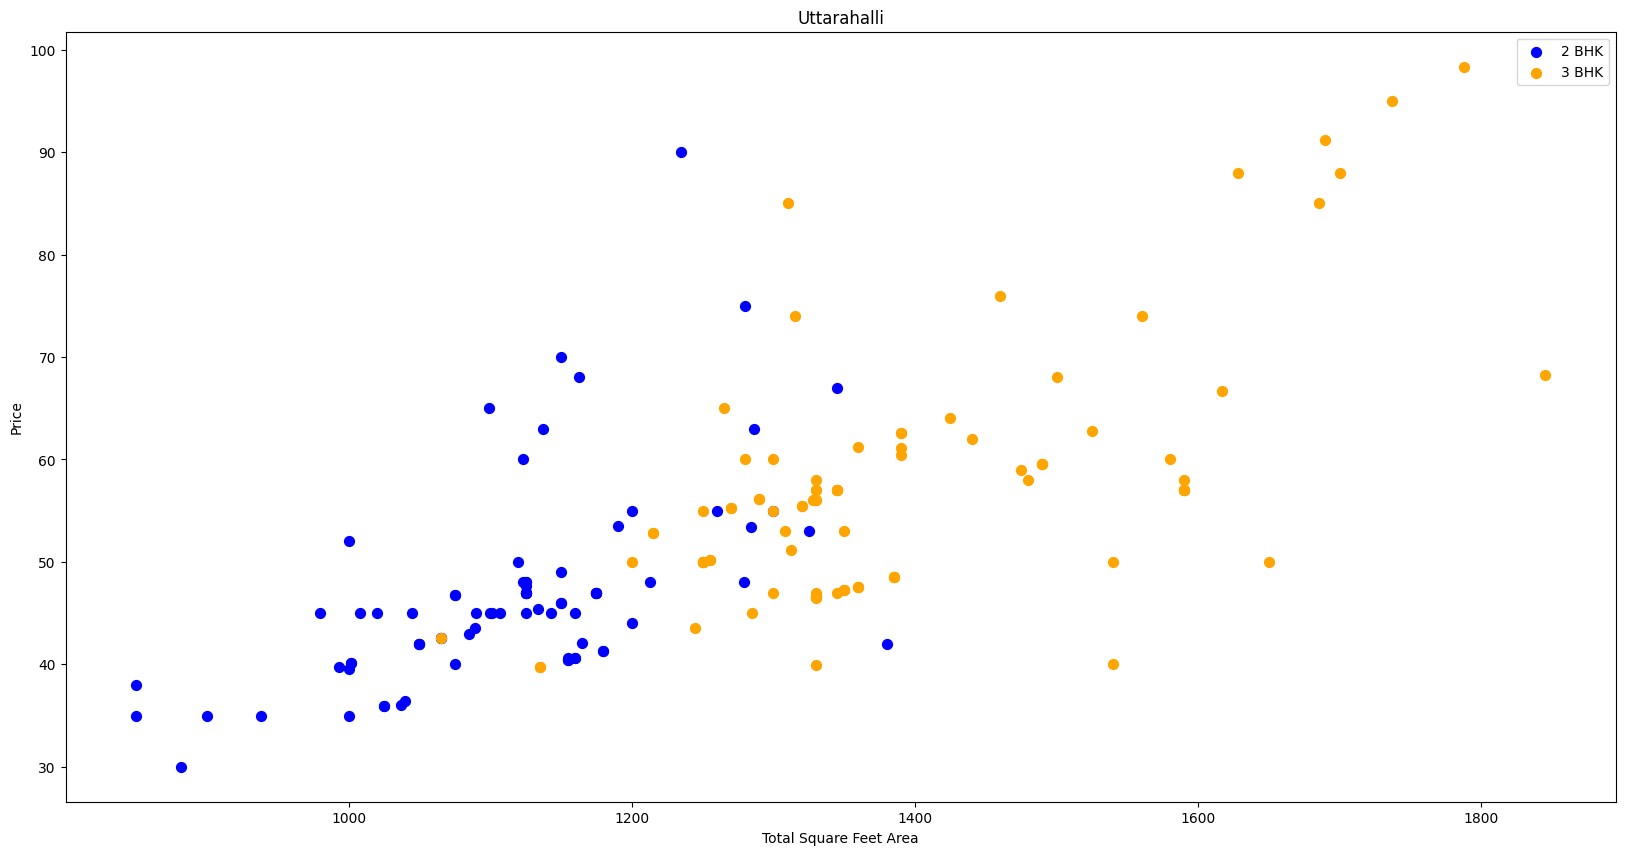

In [ ]:
plot_scatter_plot(df_copy1,'Uttarahalli')

In [ ]:
'''
Creating a new feature 'bhk_area_ratio' that represents the number of bedrooms (bhk)
per square foot of area. This gives an idea of how much space is available per bedroom.
'''
df_copy1['bhk_area_ratio'] = df_copy1['bhk'] / df_copy1['total_sqft_cleaned']

A **lower ratio** → means each bedroom has **more space** (spacious, premium property).

A **higher ratio** → means bedrooms are **cramped into less space** (cheap or congested property).

This feature can help model capture property quality beyond just raw size or number of rooms.

In [ ]:
'''
Create a new feature 'room_size_avg' that represents the average square footage per bedroom.
This helps measure how spacious each room is.
Higher values = more spacious rooms, lower values = more cramped rooms.
'''
df_copy1['room_size_avg'] = df_copy1['total_sqft_cleaned'] / df_copy1['bhk']

In [ ]:
location_price_stats = df_copy1.groupby('location')['price_per_sqft'].median()

In [ ]:
def check_outlier(row):
    median_price = location_price_stats.get(row['location'], np.nan)  # median values per location
    if pd.isna(median_price):
        return False
    # Flag if > 3x median (likely data error)
    return row['price_per_sqft'] > 3 * median_price

In [ ]:
### Creating new column to flag 'Outliers'
df_copy1['is_outlier'] = df_copy1.apply(check_outlier, axis=1)

In [ ]:
### Keep only rows where 'is_outlier' is False
df_copy1 = df_copy1[~df_copy1['is_outlier']].copy()

In [ ]:
# Price per sqft sanity check (remove extreme global outliers)
upper_limit = df_copy1['price_per_sqft'].quantile(0.99) * 3
df_copy1 = df_copy1[df_copy1['price_per_sqft'] < upper_limit]

In [ ]:
### Dropping 'is_outlier' column
df_copy1.drop(columns=['is_outlier'], inplace=True)

In [ ]:
df_copy1.shape

(10831, 13)

In [ ]:
bhk_2_3 = df_copy1[(df_copy1['bhk'] == 2) | (df_copy1['bhk'] == 3)][['bhk','price','room_size_avg','total_sqft_cleaned']]

In [ ]:
bhk_2_3.head(5)

,bhk,price,room_size_avg,total_sqft_cleaned
1,3.0,194.0,543.333333,1630.0
3,3.0,235.0,625.000000,1875.0
4,3.0,130.0,400.000000,1200.0
5,2.0,148.0,617.500000,1235.0
9,3.0,167.0,625.000000,1875.0


We are going to keep records where 2BHK price is greater than 3BHK, because this can depend on multiple factors, one of which is that 2BHK properties going to be spacious based on room size avg as compared to 3BHK, Buyers often prefer spacious rooms over having more but smaller ones. So, we are going to keep these values so that the model can learn from that.

In [ ]:
df_copy1.head(5)

,area_type,availability,location,society,total_sqft,bath,balcony,price,bhk,total_sqft_cleaned,price_per_sqft,bhk_area_ratio,room_size_avg
0,Super built-up Area,20-May,1st Block Jayanagar,NaN,2850,4.0,1.0,428.0,4.0,2850.0,15017.543860,0.001404,712.500000
1,Super built-up Area,18-Jun,1st Block Jayanagar,NaN,1630,3.0,2.0,194.0,3.0,1630.0,11901.840491,0.001840,543.333333
2,Super built-up Area,17-Dec,1st Block Jayanagar,NaN,1200,6.0,2.0,125.0,6.0,1200.0,10416.666667,0.005000,200.000000
3,Super built-up Area,Ready To Move,1st Block Jayanagar,NaN,1875,2.0,3.0,235.0,3.0,1875.0,12533.333333,0.001600,625.000000
4,Built-up Area,15-Dec,1st Block Jayanagar,Bhsic C,1200,2.0,0.0,130.0,3.0,1200.0,10833.333333,0.002500,400.000000


Now we will explore bath column

In [ ]:
df_copy1['bath'].unique()

array([ 4.,  3.,  6.,  2.,  5.,  1.,  8.,  7.,  9., nan, 12., 10., 27.,
       16., 13.])

bath column have some missing values and some extreme values for baths.

In [ ]:
df_copy1['bath'].unique()

array([ 4.,  3.,  6.,  2.,  5.,  1.,  8.,  7.,  9., nan, 12., 10., 27.,
       16., 13.])

In [ ]:
df['bath'].unique()

array([ 2.,  5.,  3.,  4.,  6.,  1.,  9., nan,  8.,  7., 11., 10., 14.,
       27., 12., 16., 40., 15., 13., 18.])

In [ ]:
'''
Remove rows where the number of bathrooms ('bath') is unrealistically high
compared to the number of bedrooms ('bhk') — specifically, more than 2 extra.
Example: If bhk = 3, we allow up to 5 baths, but drop if baths > 5.
'''
df_copy1 = df_copy1[~(df_copy1['bath']>df_copy1['bhk']+2)]

In [ ]:
df_copy1.shape

(10827, 13)

In [ ]:
df_copy2 = df_copy1.copy()

In [ ]:
### Imputing bath column with no.of bhk
df_copy2['bath'] = df_copy2['bath'].fillna(df_copy2['bhk'])

In [ ]:
df_copy2[df_copy2['bath'].isna()]

,area_type,availability,location,society,total_sqft,bath,balcony,price,bhk,total_sqft_cleaned,price_per_sqft,bhk_area_ratio,room_size_avg


In [ ]:
### Create bath-to-bedroom ratio ---
df_copy2['bath_bed_ratio'] = df_copy2['bath'] / df_copy2['bhk'].replace(0, np.nan)

This ratio helps capture the luxury level of a property — higher ratios often indicate premium homes (e.g., 2 baths for 1 bedroom).

In [ ]:
df_copy2['balcony'].unique()

array([ 1.,  2.,  3.,  0., nan])

In [ ]:
balcony_mode = df_copy2['balcony'].mode()[0]

In [ ]:
df_copy2['balcony'] = df_copy2['balcony'].fillna(balcony_mode)

In [ ]:
df_copy2['society'] = df_copy2['society'].fillna('Unknown')

In [ ]:
df_copy2.isnull().sum()

,0
area_type,0
availability,0
location,0
society,0
total_sqft,0
bath,0
balcony,0
price,0
bhk,0
total_sqft_cleaned,0


In [ ]:
df_copy2 = df_copy2.drop('availability', axis=1)
df_copy2.columns

Index(['area_type', 'location', 'society', 'total_sqft', 'bath', 'balcony',
       'price', 'bhk', 'total_sqft_cleaned', 'price_per_sqft',
       'bhk_area_ratio', 'room_size_avg', 'bath_bed_ratio'],
      dtype='object')

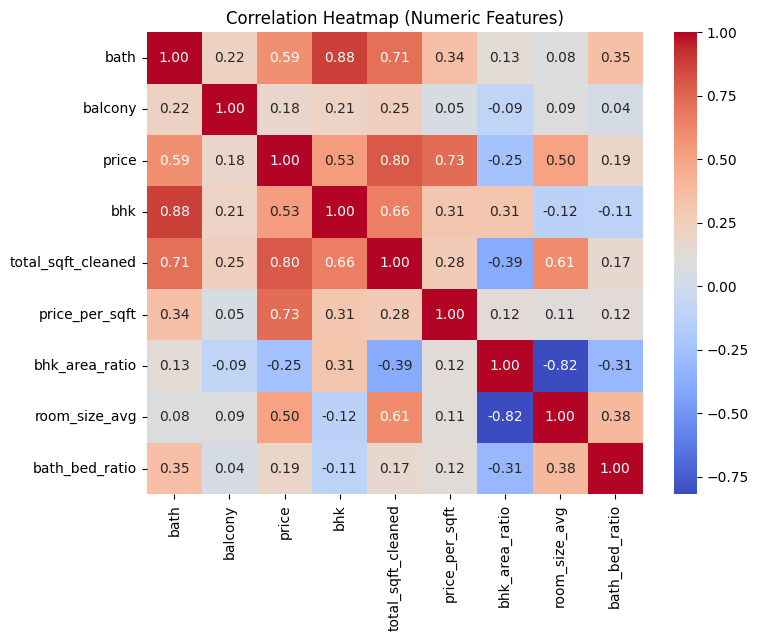

In [ ]:
#### Correlation check (numeric features only)
plt.figure(figsize=(8,6))
corr = df_copy2.corr(numeric_only=True)   # numeric-only correlation matrix
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

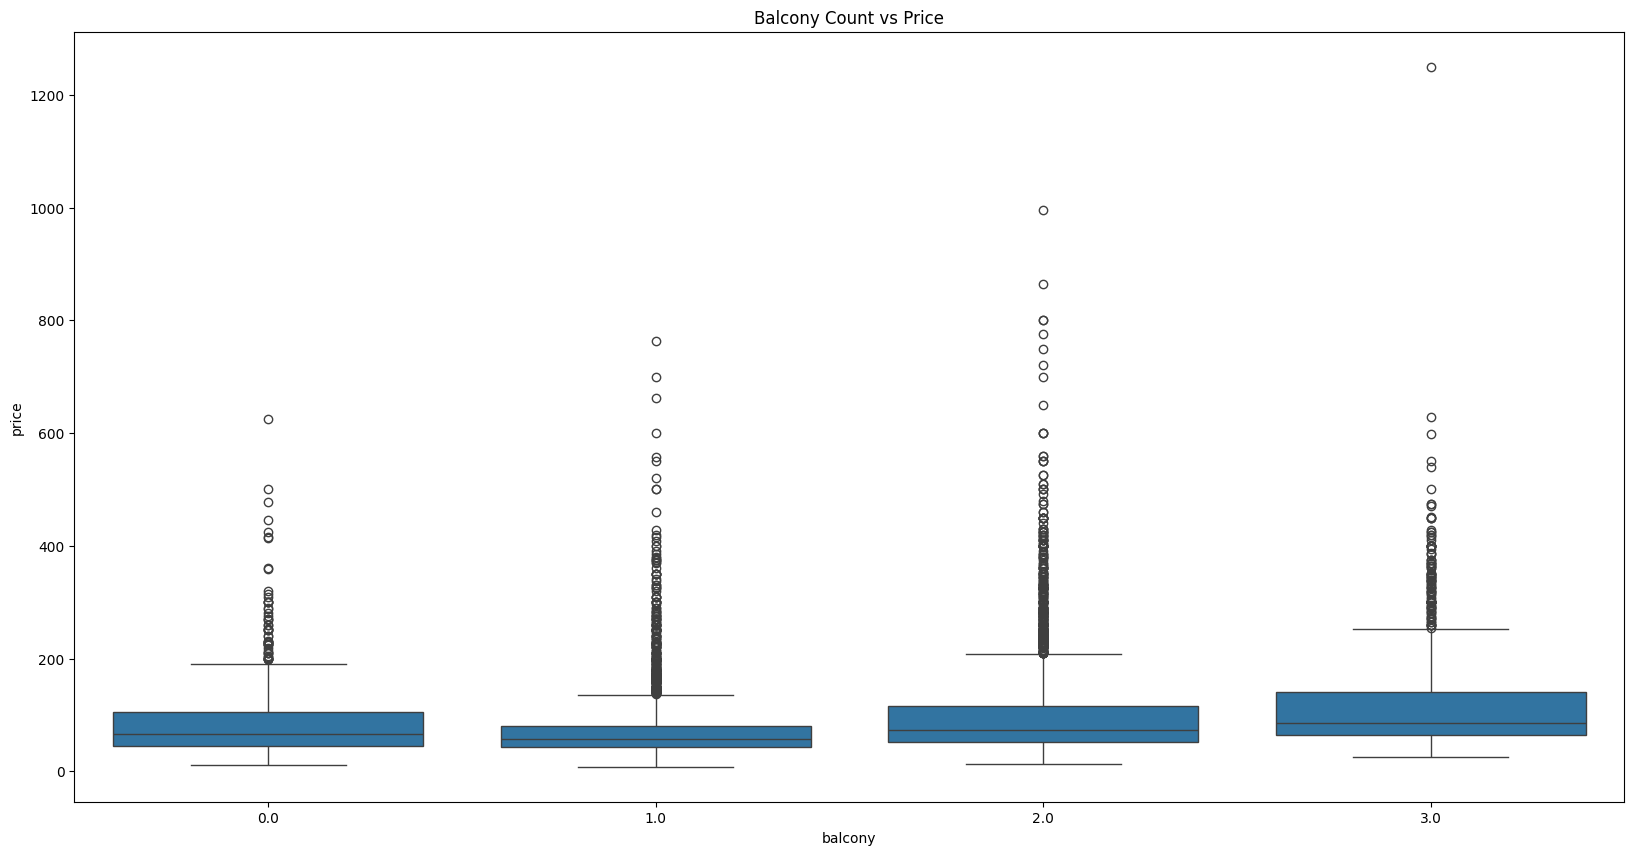

In [ ]:
### Balcony vs Price (boxplot)
sns.boxplot(x='balcony', y='price', data=df_copy2)
plt.title("Balcony Count vs Price")
plt.show()

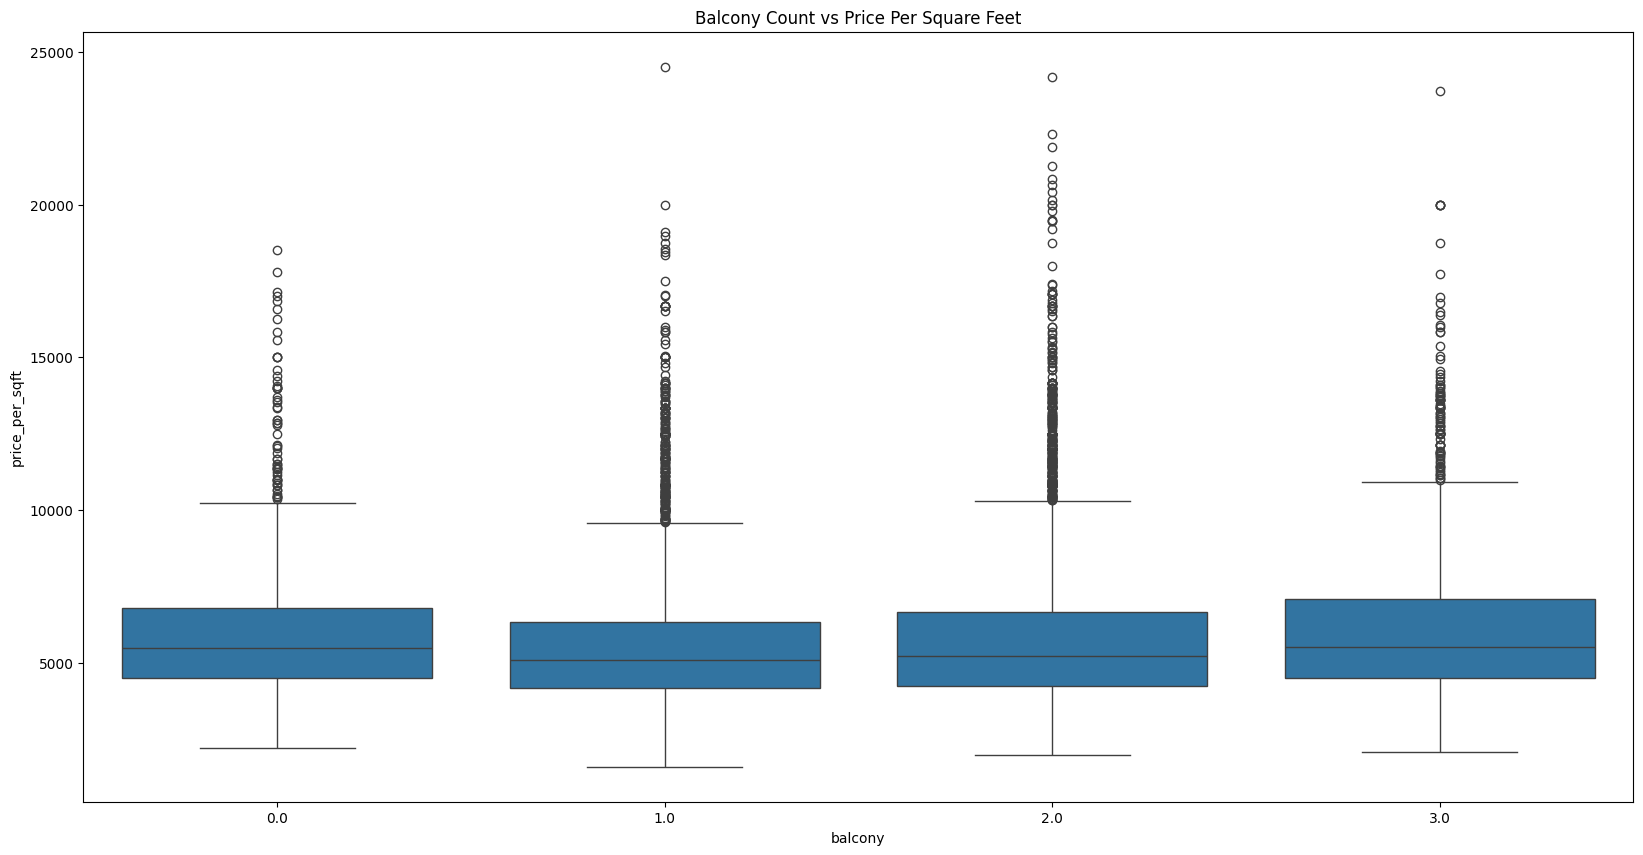

In [ ]:
### Balcony vs Price Per Square Feet (boxplot)
sns.boxplot(x='balcony', y='price_per_sqft', data=df_copy2)
plt.title("Balcony Count vs Price Per Square Feet")
plt.show()

In [ ]:
# Define extreme price outliers (e.g., > 3x 99th percentile)
upper_limit_pps = df_copy2['price_per_sqft'].quantile(0.99) * 3

In [ ]:
df_copy2['price_per_sqft'].max()

24509.803921568626

In [ ]:
upper_limit_pps

np.float64(44956.28891656285)

In [ ]:
# Remove/cap extreme price outliers that distort balcony-price plots
df_copy3 = df_copy2[df_copy2['price_per_sqft'] < upper_limit_pps].copy()

In [ ]:
df_copy3.shape

(10827, 13)

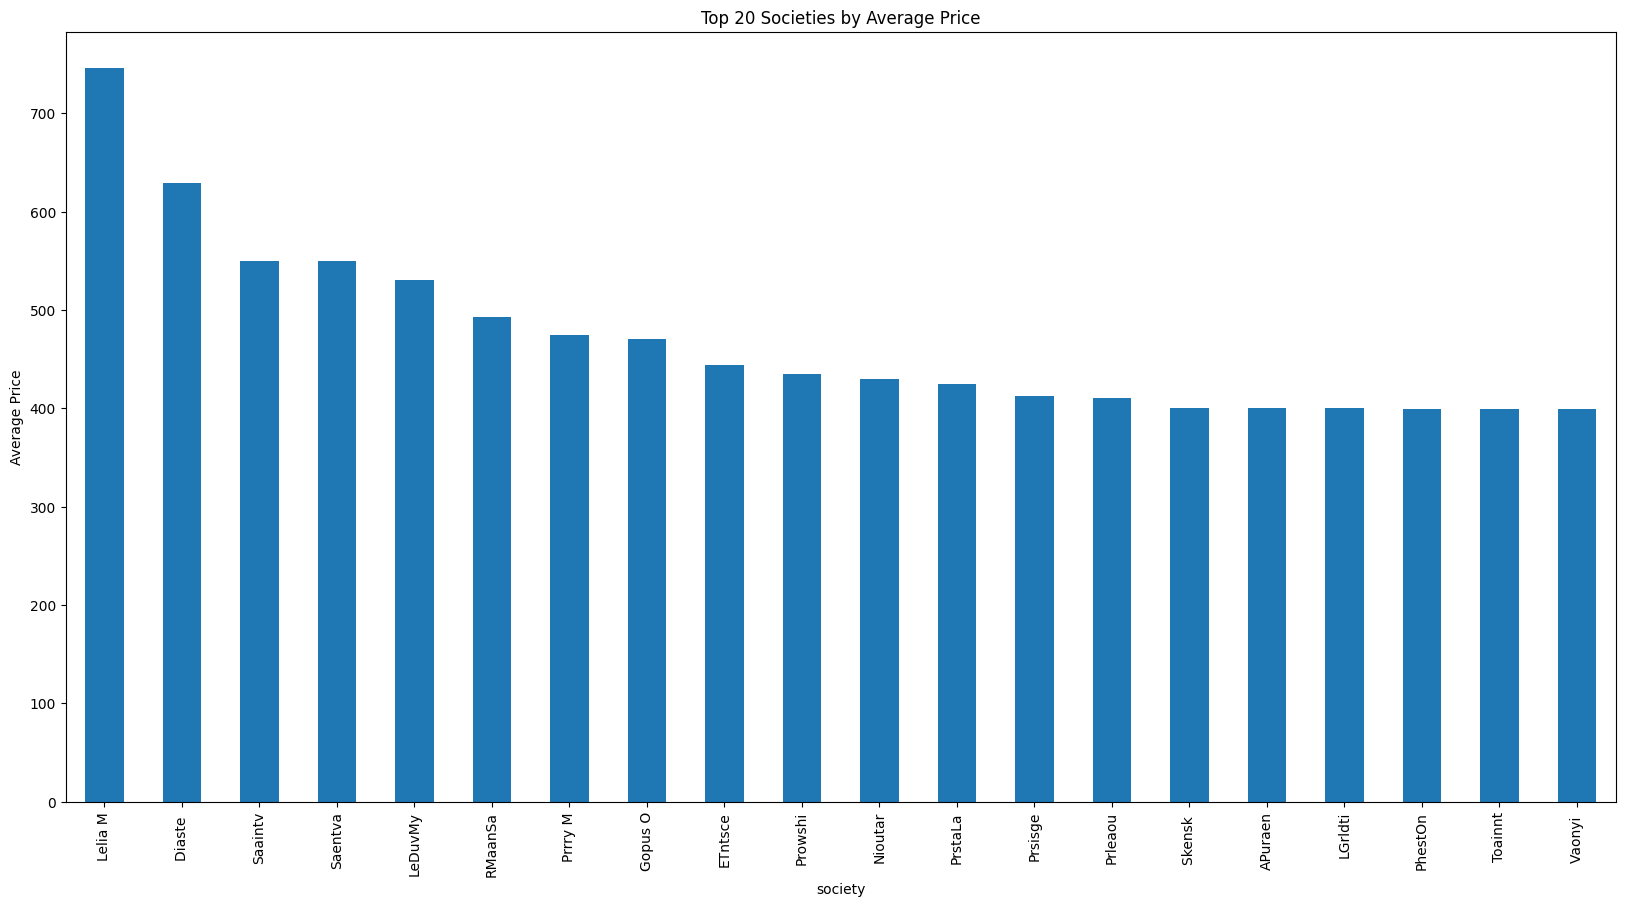

In [ ]:
### Society vs Price (target mean encoding style check)
society_price = df_copy3.groupby('society')['price'].mean().sort_values(ascending=False).head(20)

society_price.plot(kind='bar')
plt.title("Top 20 Societies by Average Price")
plt.ylabel("Average Price")
plt.show()

In [ ]:
# Step 1: Calculate median price_per_sqft per location
location_median_pps = df_copy3.groupby('location')['price_per_sqft'].transform('median')

# Step 2: Create difference feature (how much above/below market rate this property is)
df_copy3['price_per_sqft_diff'] = df_copy3['price_per_sqft'] - location_median_pps

# Step 3: Normalize the difference to avoid scale issues
# price_per_sqft_ratio → 1 → priced higher than median in that location.
# <1 → priced lower than median in that location.
df_copy3['price_per_sqft_ratio'] = df_copy3['price_per_sqft'] / location_median_pps

# Check sample
df_copy3[['location', 'total_sqft', 'price', 'price_per_sqft',
    'price_per_sqft_diff', 'price_per_sqft_ratio']].head(10)


,location,total_sqft,price,price_per_sqft,price_per_sqft_diff,price_per_sqft_ratio
0,1st Block Jayanagar,2850,428.0,15017.543860,2758.974359,1.225065
1,1st Block Jayanagar,1630,194.0,11901.840491,-356.729010,0.970900
2,1st Block Jayanagar,1200,125.0,10416.666667,-1841.902834,0.849746
3,1st Block Jayanagar,1875,235.0,12533.333333,274.763833,1.022414
4,1st Block Jayanagar,1200,130.0,10833.333333,-1425.236167,0.883736
5,1st Block Jayanagar,1235,148.0,11983.805668,-274.763833,0.977586
6,1st Block Jayanagar,2750,413.0,15018.181818,2759.612318,1.225117
7,1st Block Jayanagar,2450,368.0,15020.408163,2761.838663,1.225299
8,1st Phase JP Nagar,2825,250.0,8849.557522,610.563811,1.074107
9,1st Phase JP Nagar,1875,167.0,8906.666667,667.672956,1.081038


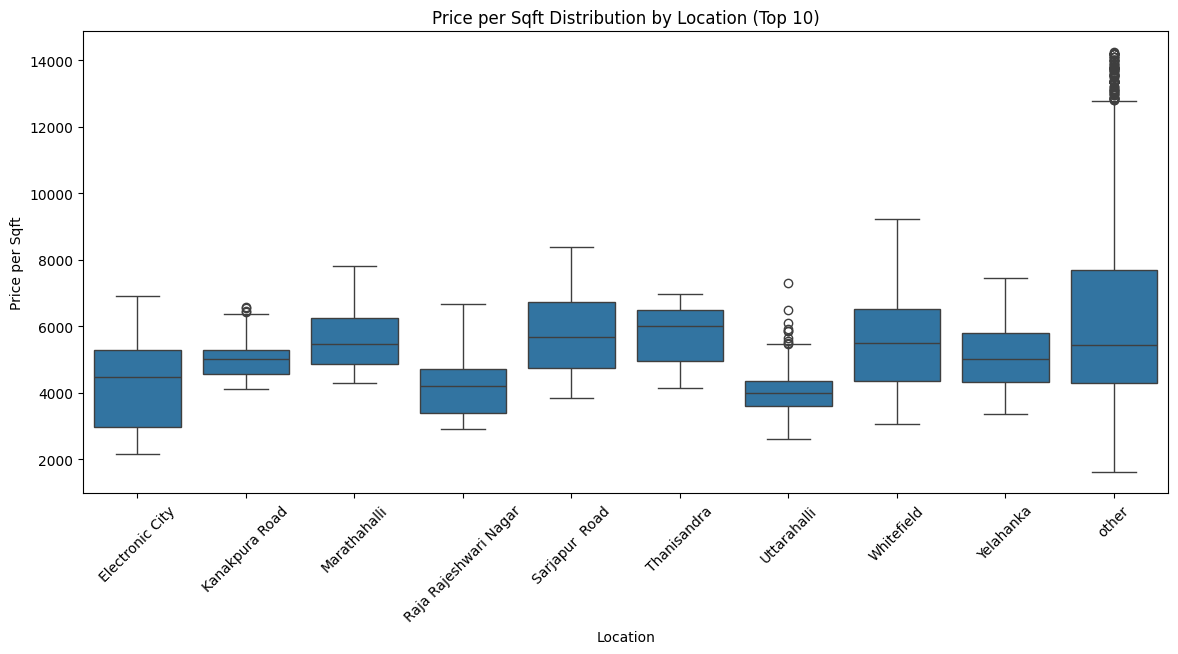

In [ ]:
### Boxplot: Price per sqft distribution by location ---
plt.figure(figsize=(14, 6))
top_locations = df_copy3['location'].value_counts().nlargest(10).index  # top 10 locations
sns.boxplot(data=df_copy3[df_copy3['location'].isin(top_locations)],
            x='location', y='price_per_sqft')
plt.xticks(rotation=45)
plt.title("Price per Sqft Distribution by Location (Top 10)")
plt.ylabel("Price per Sqft")
plt.xlabel("Location")
plt.show()

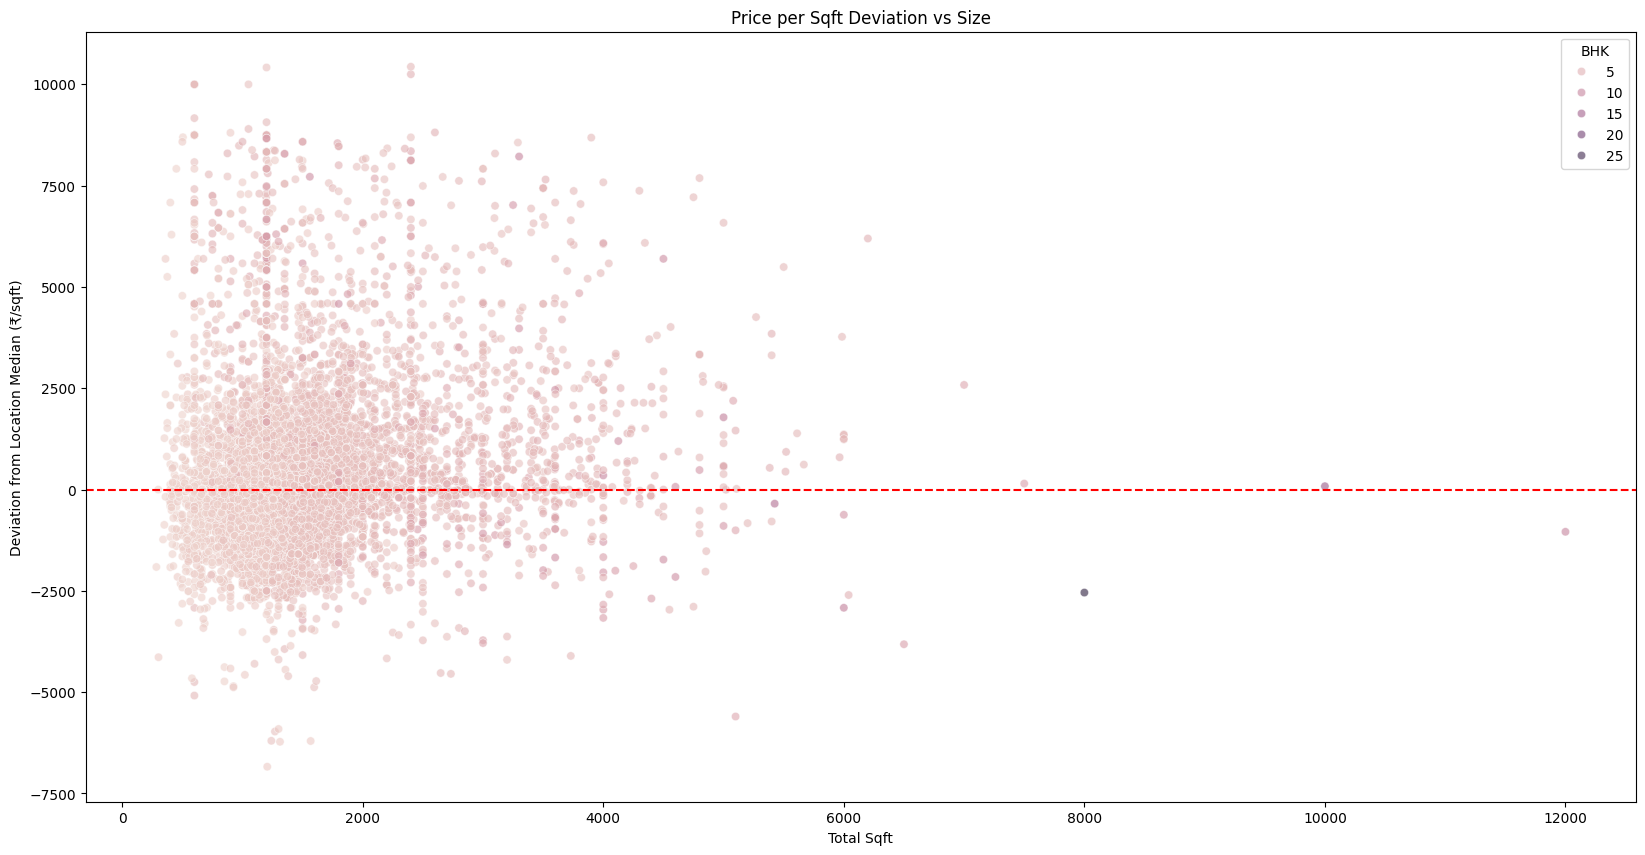

In [ ]:
### Scatterplot: Market deviation vs Size ---
sns.scatterplot(data=df_copy3, x='total_sqft_cleaned', y='price_per_sqft_diff',
                hue='bhk', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')  # baseline (median market rate)
plt.title("Price per Sqft Deviation vs Size")
plt.xlabel("Total Sqft")
plt.ylabel("Deviation from Location Median (₹/sqft)")
plt.legend(title="BHK")
plt.show()

In [ ]:
# Step 1: Define thresholds (domain-driven)
# ±20% of location median = Fairly priced
df_copy3['price_status'] = 'Fair'

df_copy3.loc[df_copy3['price_per_sqft_ratio'] > 1.20, 'price_status'] = 'Overpriced'
df_copy3.loc[df_copy3['price_per_sqft_ratio'] < 0.80, 'price_status'] = 'Underpriced'

# Step 2: Check counts
print(df_copy3['price_status'].value_counts())

price_status
Fair           6973
Overpriced     2242
Underpriced    1612
Name: count, dtype: int64


/tmp/ipython-input-1987775388.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_copy3, x='price_status', palette="coolwarm", order=["Underpriced","Fair","Overpriced"])


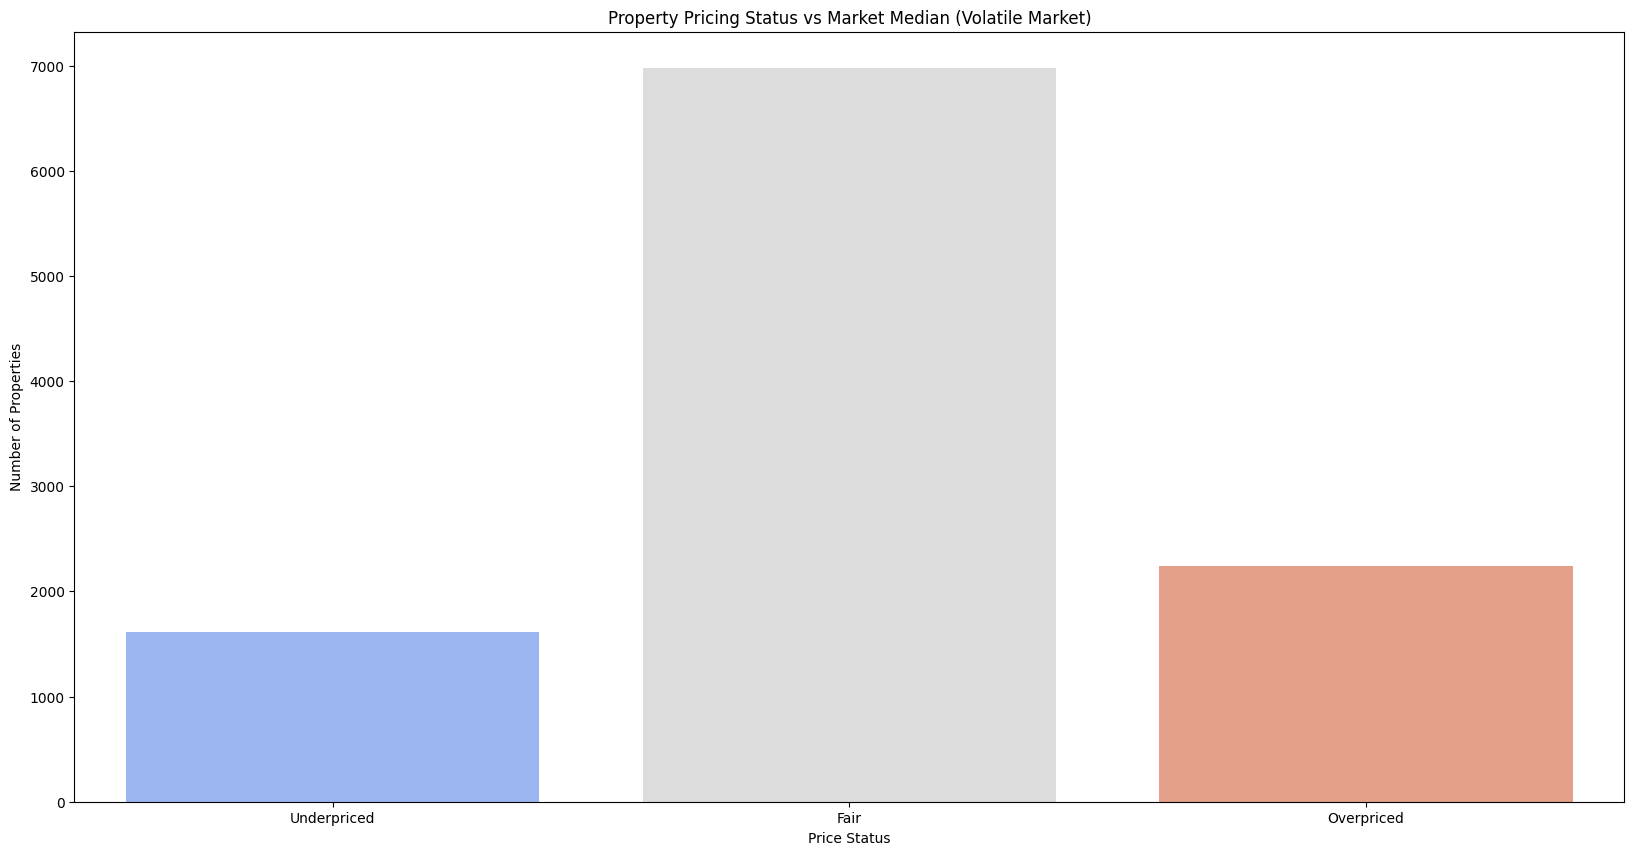

In [ ]:
sns.countplot(data=df_copy3, x='price_status', palette="coolwarm", order=["Underpriced","Fair","Overpriced"])
plt.title("Property Pricing Status vs Market Median (Volatile Market)")
plt.xlabel("Price Status")
plt.ylabel("Number of Properties")
plt.show()

In [ ]:
df_copy3.columns

Index(['area_type', 'location', 'society', 'total_sqft', 'bath', 'balcony',
       'price', 'bhk', 'total_sqft_cleaned', 'price_per_sqft',
       'bhk_area_ratio', 'room_size_avg', 'bath_bed_ratio',
       'price_per_sqft_diff', 'price_per_sqft_ratio', 'price_status'],
      dtype='object')

In [ ]:
df_copy3[['bhk_area_ratio','room_size_avg']].corr()

,bhk_area_ratio,room_size_avg
bhk_area_ratio,1.000000,-0.819051
room_size_avg,-0.819051,1.000000


In [ ]:
# Select relevant features
X = df_copy3[['bhk_area_ratio', 'room_size_avg']].copy()
X = add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

          feature         VIF
0           const  124.340241
1  bhk_area_ratio    3.038078
2   room_size_avg    3.038078


In [ ]:
df_copy3[['total_sqft_cleaned','price_per_sqft']].corr()

,total_sqft_cleaned,price_per_sqft
total_sqft_cleaned,1.000000,0.279419
price_per_sqft,0.279419,1.000000


In [ ]:
# Select relevant features
X = df_copy3[['total_sqft_cleaned', 'price_per_sqft']].copy()
X = add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              feature       VIF
0               const  8.809648
1  total_sqft_cleaned  1.084687
2      price_per_sqft  1.084687


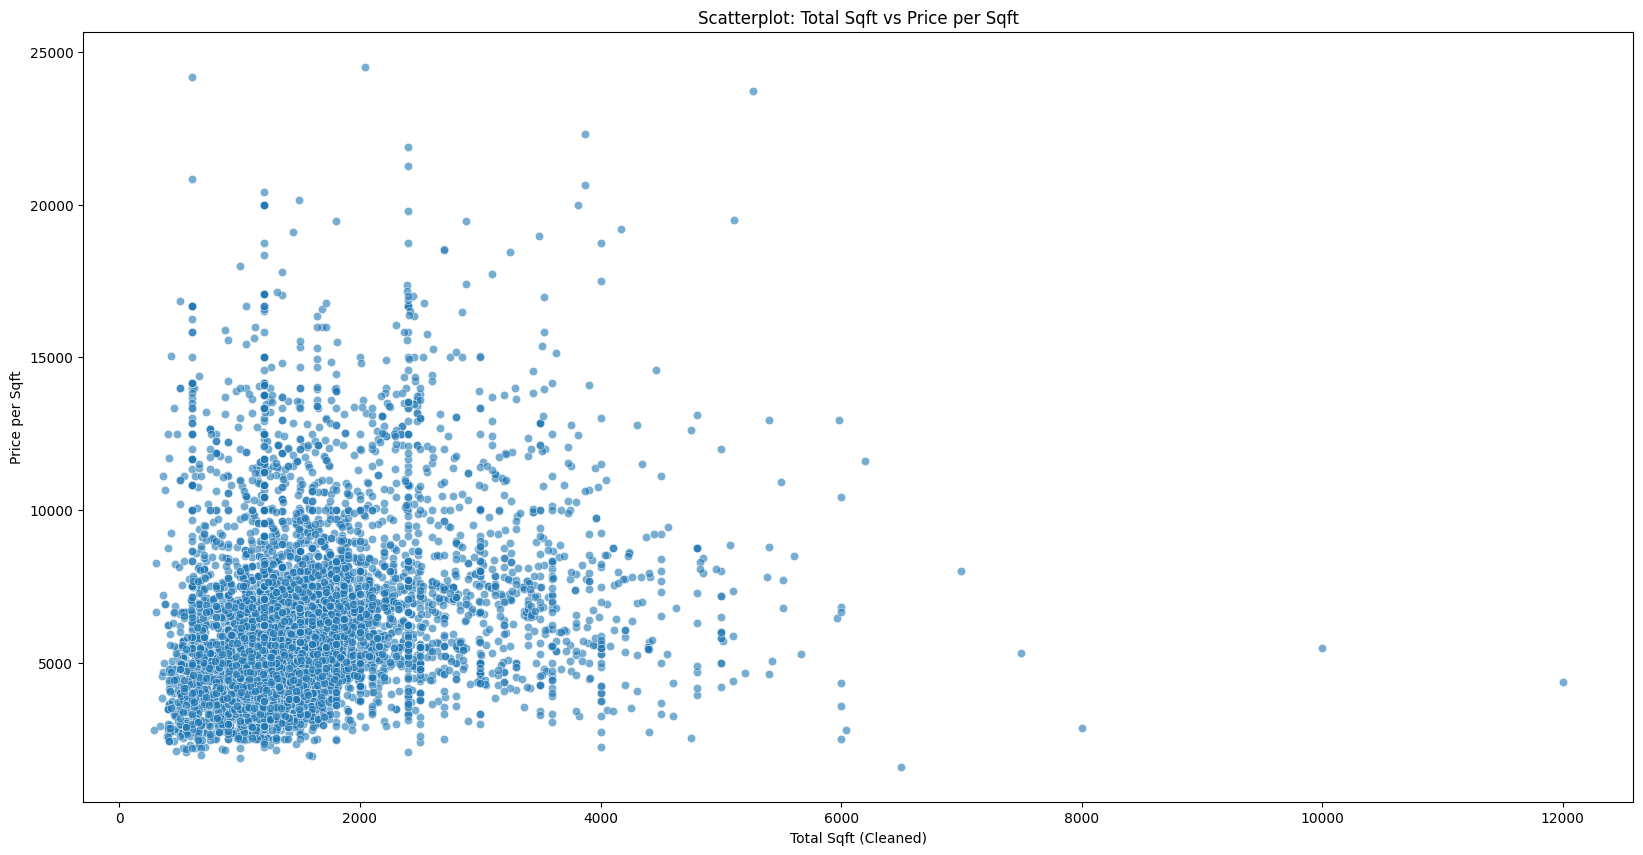

In [ ]:
sns.scatterplot(data=df_copy3, x='total_sqft_cleaned', y='price_per_sqft', alpha=0.6)

plt.title("Scatterplot: Total Sqft vs Price per Sqft")
plt.xlabel("Total Sqft (Cleaned)")
plt.ylabel("Price per Sqft")
plt.show()

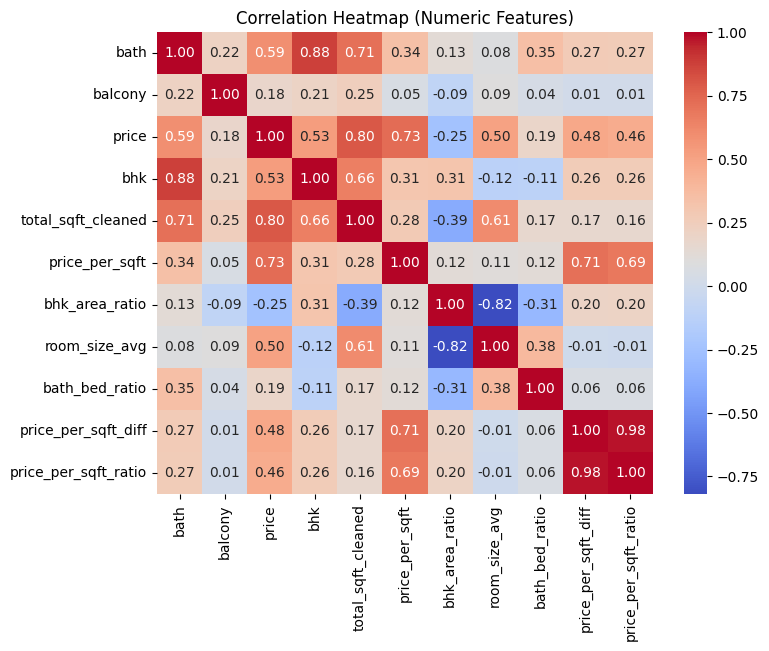

In [ ]:
plt.figure(figsize=(8,6))
corr = df_copy3.corr(numeric_only=True)   # numeric-only correlation matrix
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()

In [ ]:
df_copy3 = df_copy3.drop('total_sqft', axis=1)

In [ ]:
df_copy3.select_dtypes(include='object').columns

Index(['area_type', 'location', 'society', 'price_status'], dtype='object')

In [ ]:
df_copy3['price_status'].nunique()

3

In [ ]:
df_copy4 = df_copy3.copy()
df_copy4.shape

(10827, 15)

In [ ]:
### Label Encoding 'location' & 'society'
loc_le = LabelEncoder()
soc_le = LabelEncoder()

df_copy4['location'] = loc_le.fit_transform(df_copy4['location'])
df_copy4['society'] = soc_le.fit_transform(df_copy4['society'])

In [ ]:
### Creating OneHotEncoding for low cardinality columns
df_copy4 = pd.get_dummies(df_copy4, columns=['area_type','price_status'], drop_first=True)

### Calculating Feature Importance

In [ ]:
X = df_copy4.drop('price', axis=1)
y = df_copy4['price']

model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X, y)

importances = pd.DataFrame({
    'feature' : X.columns,
    'importance' : model.feature_importances_
}).sort_values(by='importance', ascending=False)

In [ ]:
len(importances)

17

In [ ]:
print(importances)

                           feature  importance
5               total_sqft_cleaned    0.634120
6                   price_per_sqft    0.346945
7                   bhk_area_ratio    0.007857
8                    room_size_avg    0.006274
11            price_per_sqft_ratio    0.000824
0                         location    0.000762
10             price_per_sqft_diff    0.000728
3                          balcony    0.000589
2                             bath    0.000480
1                          society    0.000351
14  area_type_Super built-up  Area    0.000327
4                              bhk    0.000294
9                   bath_bed_ratio    0.000285
15         price_status_Overpriced    0.000100
13            area_type_Plot  Area    0.000045
12          area_type_Carpet  Area    0.000014
16        price_status_Underpriced    0.000005


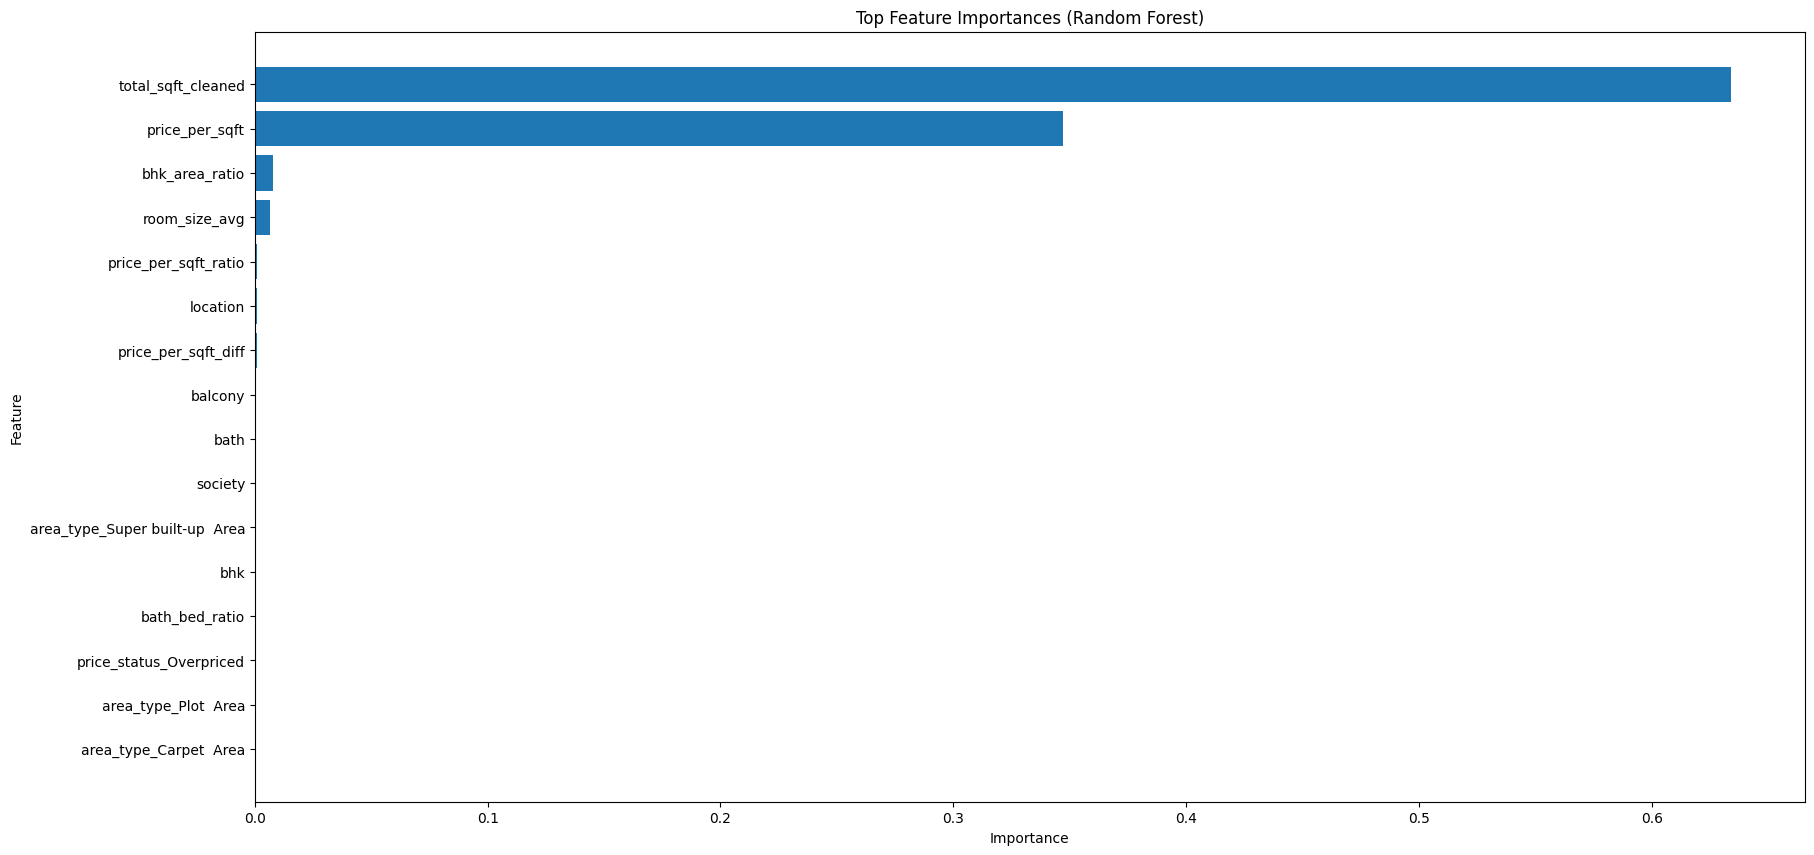

In [ ]:
plt.barh(importances['feature'][:16][::-1], importances['importance'][:16][::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

| Feature                           | Model Importance          | Domain Knowledge             | Action      |
| --------------------------------- | ------------------------- | ---------------------------- | ----------- |
| total\_sqft\_cleaned              | High                      | Critical                     | Keep        |
| price\_per\_sqft                  | High                      | Critical (but watch leakage) | Keep        |
| bhk\_area\_ratio, room\_size\_avg | Low                       | Important for quality        | Keep        |
| bath, balcony                     | Very Low                  | Moderate relevance           | Keep        |
| location                          | Very Low (encoding issue) | Most critical                | Re-engineer |
| society                           | Very Low                  | Only luxury impact           | Drop/Impute |
| area\_type\_\*                    | Negligible                | Weak                         | Drop        |
| price\_status\_\*                 | Negligible                | Weak                         | Drop        |


In [ ]:
df_copy3.columns

Index(['area_type', 'location', 'society', 'bath', 'balcony', 'price', 'bhk',
       'total_sqft_cleaned', 'price_per_sqft', 'bhk_area_ratio',
       'room_size_avg', 'bath_bed_ratio', 'price_per_sqft_diff',
       'price_per_sqft_ratio', 'price_status'],
      dtype='object')

In [ ]:
df_copy5_1 = df_copy3.drop([
    'area_type',
    'society',
    'bhk_area_ratio',
    'bath_bed_ratio',
    'price_per_sqft_diff',
    'price_per_sqft_ratio',
    'price_status'
], axis=1)

In [ ]:
df_copy5_1.head(3)

,location,bath,balcony,price,bhk,total_sqft_cleaned,price_per_sqft,room_size_avg
0,1st Block Jayanagar,4.0,1.0,428.0,4.0,2850.0,15017.543860,712.500000
1,1st Block Jayanagar,3.0,2.0,194.0,3.0,1630.0,11901.840491,543.333333
2,1st Block Jayanagar,6.0,2.0,125.0,6.0,1200.0,10416.666667,200.000000


In [ ]:
dummies = pd.get_dummies(df_copy5_1.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_copy6 = pd.concat([df_copy5_1.drop('location', axis='columns'),dummies.drop('other', axis='columns')], axis='columns')
df_copy6.head(3)

,bath,balcony,price,bhk,total_sqft_cleaned,price_per_sqft,room_size_avg,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,4.0,1.0,428.0,4.0,2850.0,15017.543860,712.500000,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,3.0,2.0,194.0,3.0,1630.0,11901.840491,543.333333,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,6.0,2.0,125.0,6.0,1200.0,10416.666667,200.000000,True,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
X = df_copy6.drop('price', axis='columns')

In [ ]:
y = df_copy6['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [ ]:
lr = LinearRegression()

lr.fit(X_train, y_train)

lr.score(X_test, y_test)

0.9350506568350806

In [ ]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.92778657, 0.93356006, 0.92562292, 0.93930128, 0.9375384 ])

In [ ]:
ridge = Ridge(alpha=1.0)

ridge.fit(X_train, y_train)

ridge.score(X_test, y_test)

0.9366115796580287

In [ ]:
rf = RandomForestRegressor(n_estimators=300, max_depth=12, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

rf.score(X_test, y_test)

0.9928026386683704

In [ ]:
y_pred_rf = rf.predict(X_test)

In [ ]:
def evaluate_model(name, y_test, y_pred):
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f"{name}: R² = {r2:.3f}, RMSE = {rmse:.2f}")

In [ ]:
evaluate_model('Random Forest', y_test, y_pred_rf)

Random Forest: R² = 0.993, RMSE = 6.35


In [ ]:
rf_cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(RandomForestRegressor(), X, y, cv=rf_cv)

array([0.98874846, 0.98926818, 0.99447499, 0.99429251, 0.98998425])

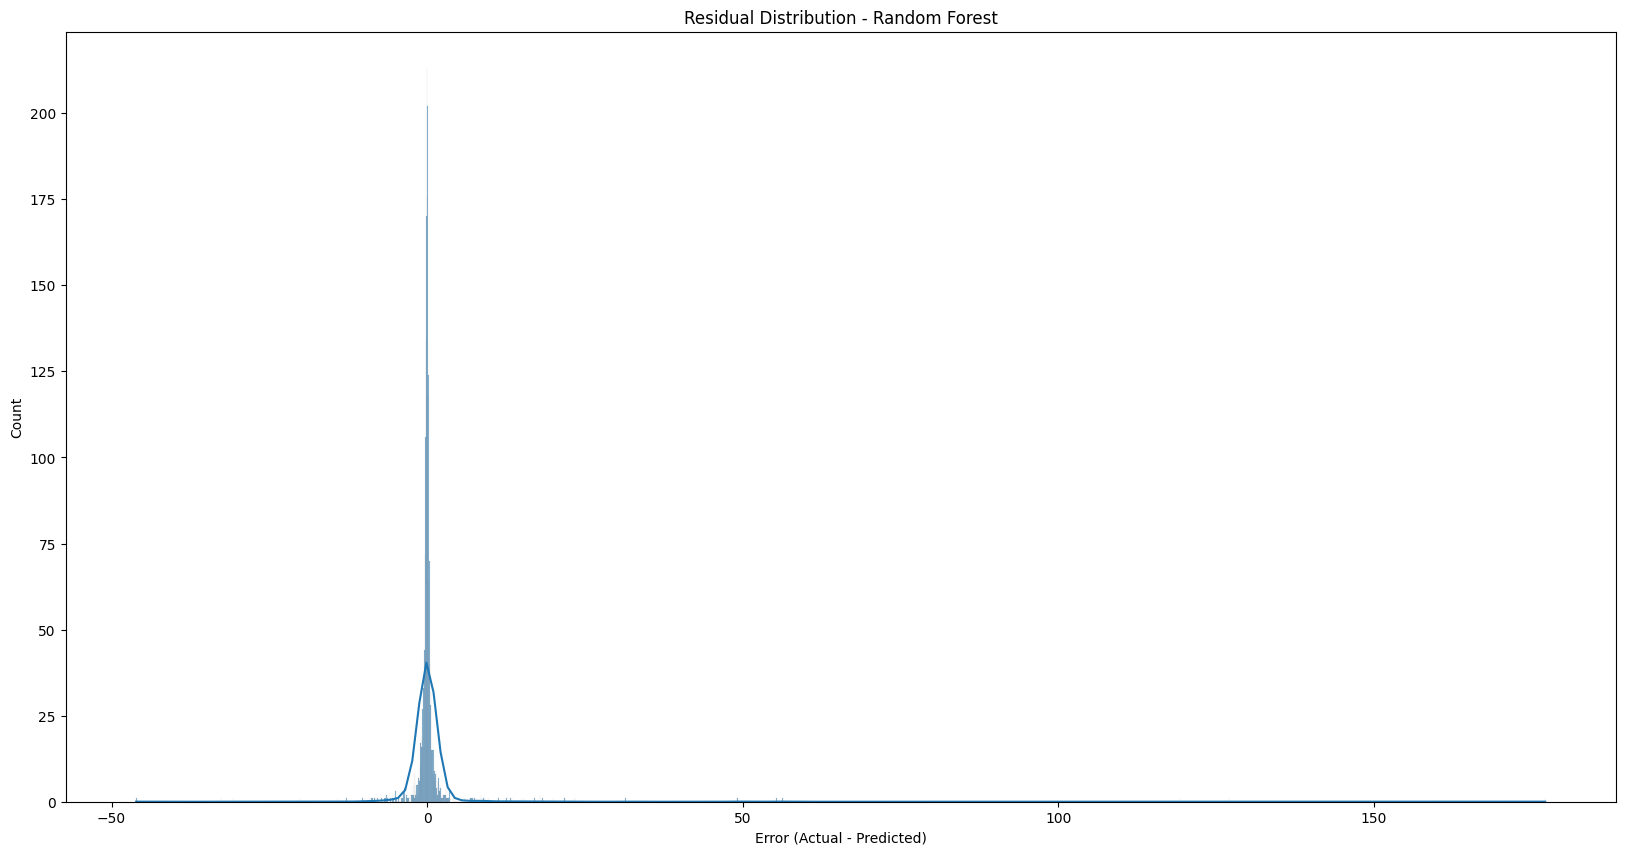

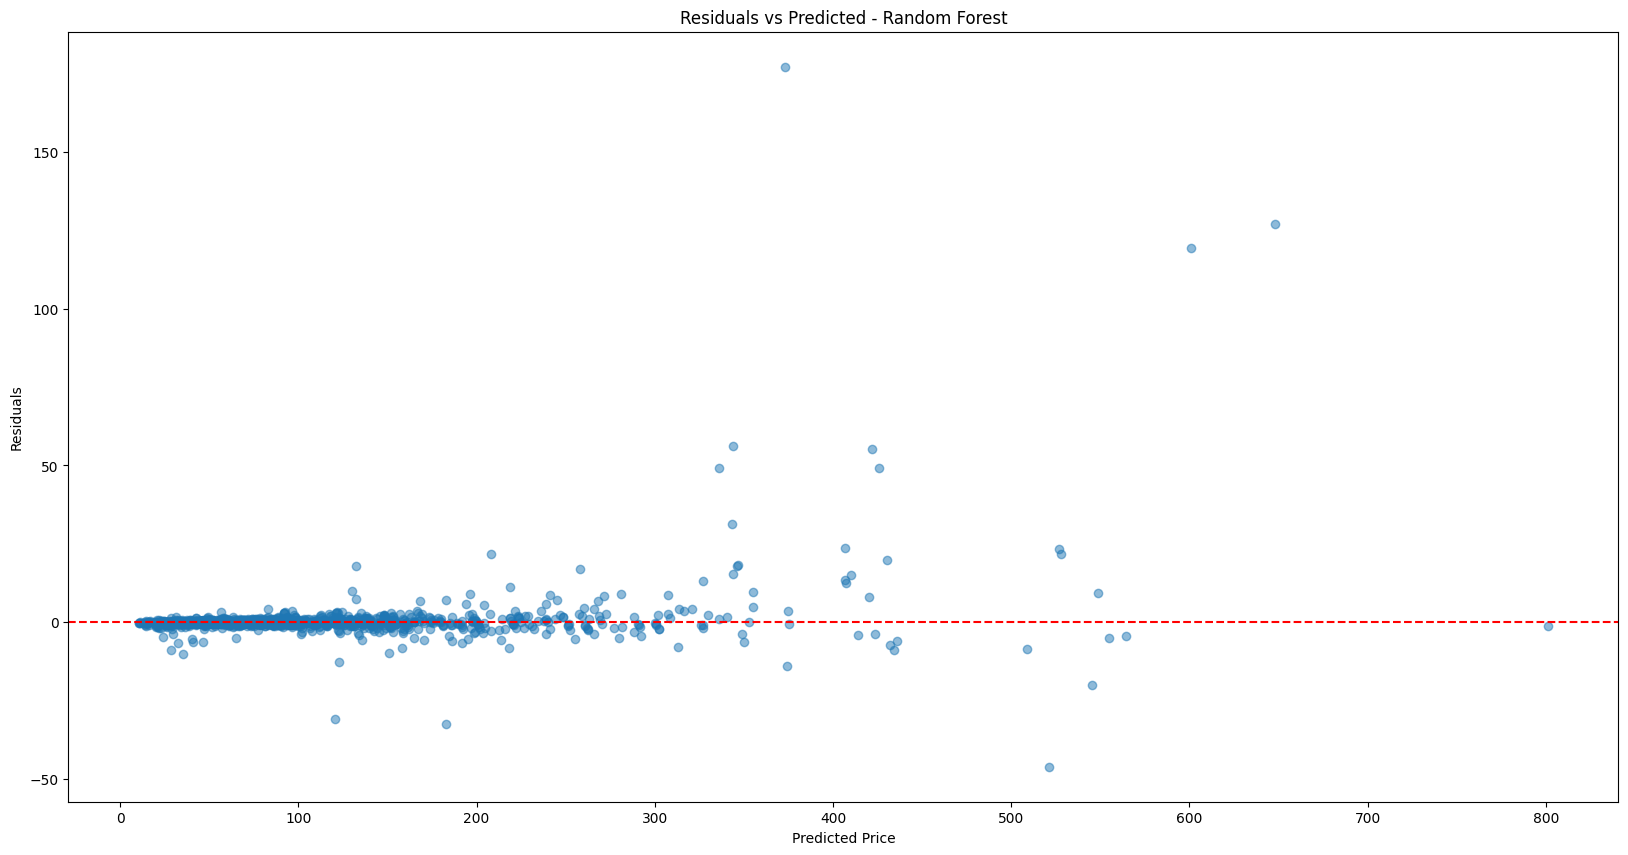

In [ ]:
# Residuals
residuals = y_test - y_pred_rf

# Plot residuals distribution
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution - Random Forest")
plt.xlabel("Error (Actual - Predicted)")
plt.show()

# Scatter plot: residuals vs predicted
plt.scatter(y_pred_rf, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted - Random Forest")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.show()

**residual distribution for Random Forest**

### Strong Peak at 0

    Most residuals (errors) are clustered very tightly around 0.

    This means the model is predicting extremely close to actual house prices for the majority of properties.

### Symmetry Around 0

    The distribution looks roughly centered at 0, without a large bias to the left or right.

    This indicates the model is not systematically overpricing or underpricing.

### Thin Spread

    The bulk of residuals are within a small range (say -10 to +10), which is excellent.

    It means the errors are small relative to the price scale.

### Long Tails (Outliers)

    You can see a few extreme values stretching as far as +100 or +150.

    These are rare cases where the model predicted poorly, likely luxury or unusual properties (e.g., penthouses, builder-floor anomalies, or irregular sqft pricing).

**Residuals vs Predicted Price for Random Forest**

### Cluster Around 0 for Most Predictions

    For predicted prices below ~200, residuals are very tightly centered around 0.

    This means the model is very accurate for low-to-mid range properties.

### Slightly Larger Spread at Higher Prices

    As predicted price increases (>200), residuals start spreading out more.

    This is common in real estate: luxury/premium properties don’t follow the same price-per-sqft rules as mid-market homes.

### Outliers in Luxury Segment

    A few residuals are extremely high (up to 150–180) around predicted prices ~350–700.

    This shows the model underestimates some luxury properties (predicts too low compared to actual).

    Similarly, a few large negative residuals mean overestimation for some expensive units.

### No Clear Bias Line

    The residuals don’t show a strong trend (like steadily increasing or decreasing with price).

    That’s good: it means the model does not have a systematic bias (e.g., always underpredicting at high end).

In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators = 500,
    learning_rate = 0.05,
    max_depth = 8,
    subsample = 0.8,
    colsample_bytree = 0.8,
    random_state = 42,
    n_jobs = -1
)

xgb_model.fit(X_train, y_train)

xgb_model.score(X_test, y_test)

0.990872922205558

In [ ]:
y_pred_xgb = xgb_model.predict(X_test)

In [ ]:
evaluate_model('XGBoost', y_test, y_pred_xgb)

XGBoost: R² = 0.991, RMSE = 7.15


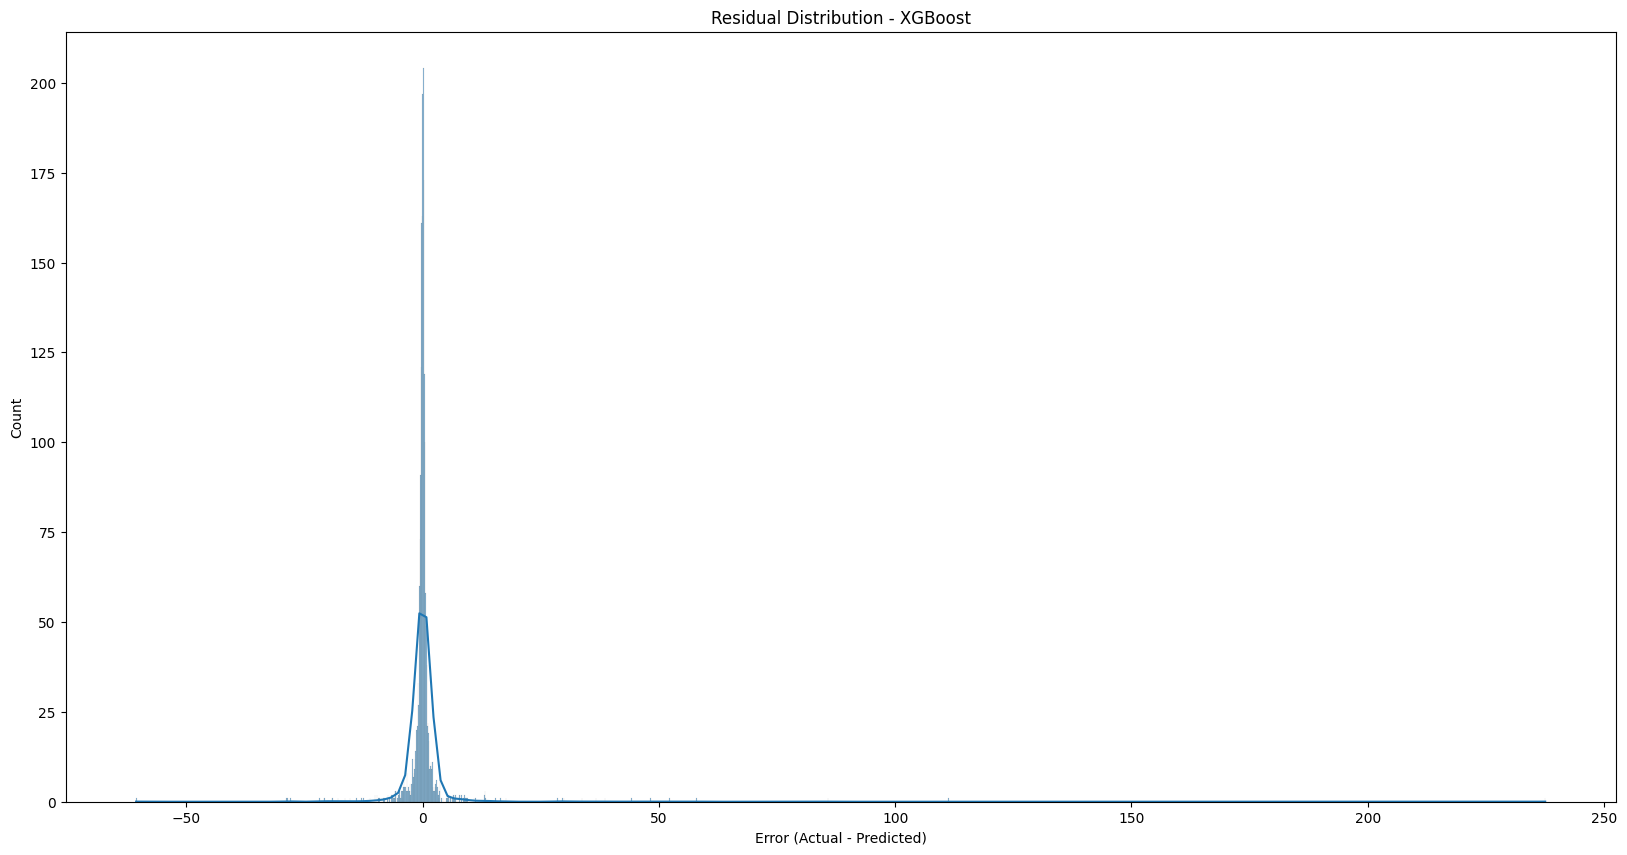

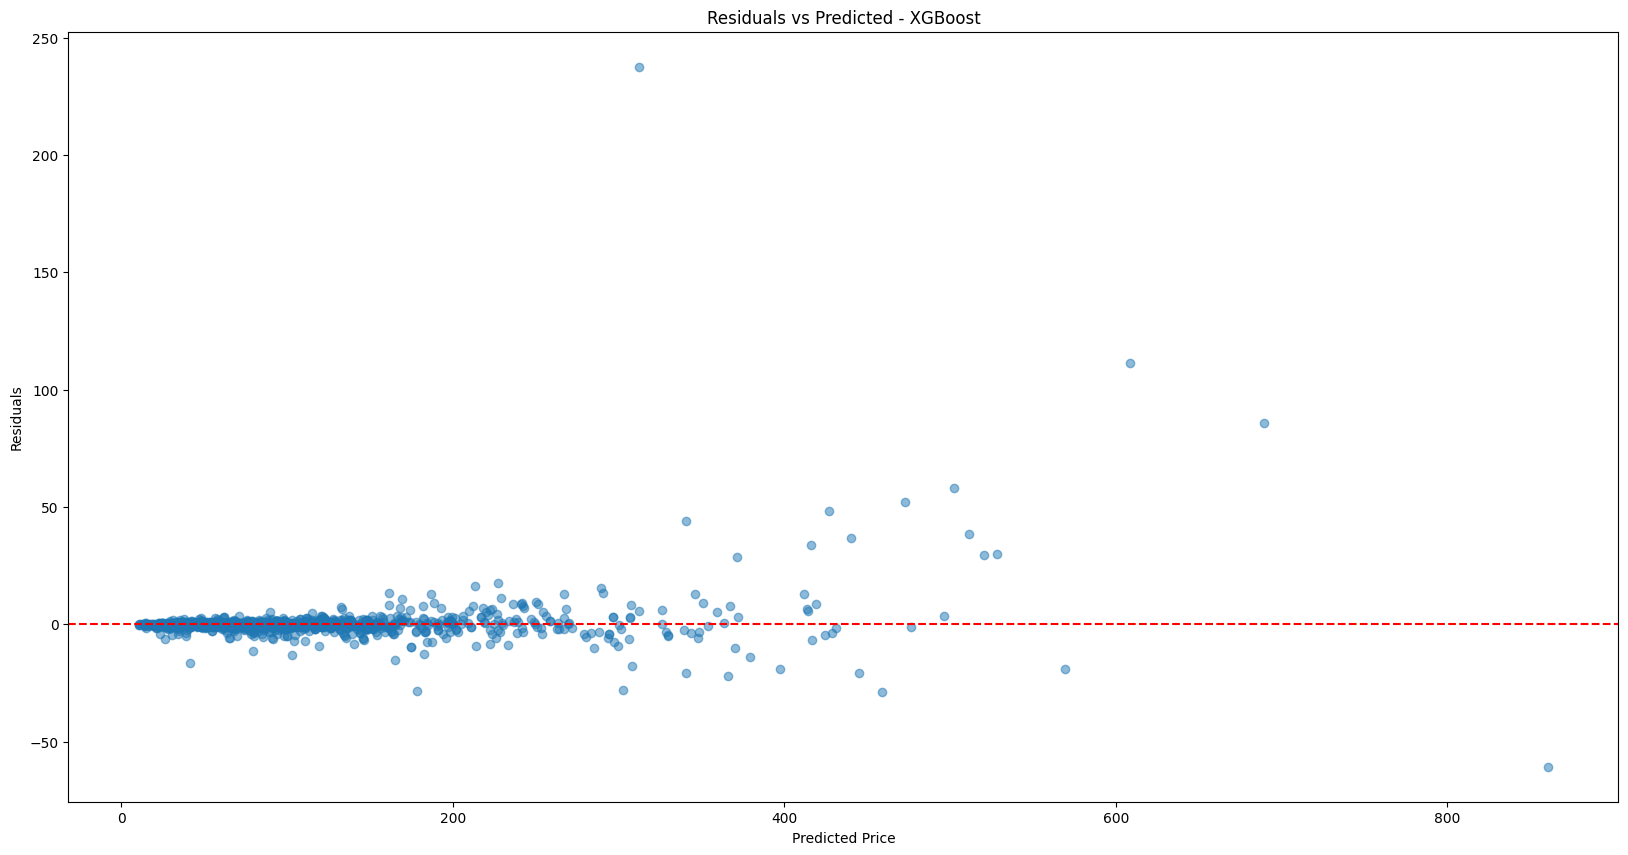

In [ ]:
# Residuals
xgb_residuals = y_test - y_pred_xgb

# Plot residuals distribution
sns.histplot(xgb_residuals, kde=True)
plt.title("Residual Distribution - XGBoost")
plt.xlabel("Error (Actual - Predicted)")
plt.show()

# Scatter plot: residuals vs predicted
plt.scatter(y_pred_xgb, xgb_residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title("Residuals vs Predicted - XGBoost")
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.show()

In [ ]:
### Hyperparameter grid
param_dist = {
    'n_estimators': [200, 300, 400, 500],       # number of trees
    'max_depth': [8, 10, 12, 15, None],         # tree depth
    'max_features': ['auto', 'sqrt', 0.7, 0.8], # features per split
    'min_samples_split': [2, 5, 10],            # min samples to split node
    'min_samples_leaf': [1, 2, 4],              # min samples per leaf
    'bootstrap': [True, False]                  # bootstrap sampling
}

In [ ]:
### RandomizedSearchCV setup
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=10,             # number of random combinations to try
    cv=5,                  # 5-fold CV
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='r2'           # optimize for R²
)

# Fit search
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.12/dist-packages/sklearn/utils/_pa

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(max_depth=12,
                                                   n_estimators=300, n_jobs=-1,
                                                   random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [8, 10, 12, 15, None],
                                        'max_features': ['auto', 'sqrt', 0.7,
                                                         0.8],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 300, 400, 500]},
                   random_state=42, scoring='r2', verbose=2)

In [ ]:
### Best parameters
print("Best parameters:", rf_random.best_params_)
print("Best CV score (R²):", rf_random.best_score_)

Best parameters: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 0.7, 'max_depth': 12, 'bootstrap': False}
Best CV score (R²): 0.9869091832506613


In [ ]:
### Evaluate on test set
best_rf = rf_random.best_estimator_
test_r2 = best_rf.score(X_test, y_test)
print("Test R²:", test_r2)

Test R²: 0.9900380035810173


In [ ]:
### Save base model
with open("random_forest_base.pkl", "wb") as f:
    pickle.dump(rf, f)

### Save tuned model
with open("random_forest_tuned.pkl", "wb") as f:
    pickle.dump(best_rf, f)

print("✅ Both models saved successfully!")


✅ Both models saved successfully!


In [ ]:
### Save base model
joblib.dump(rf, "random_forest_base.joblib")

### Save tuned model
joblib.dump(best_rf, "random_forest_tuned.joblib")

print("✅ Both models saved successfully in joblib format!")


✅ Both models saved successfully in joblib format!


In [ ]:
X.columns

Index(['bath', 'balcony', 'bhk', 'total_sqft_cleaned', 'price_per_sqft',
       'room_size_avg', '1st Block Jayanagar', '1st Phase JP Nagar',
       '2nd Phase Judicial Layout', '2nd Stage Nagarbhavi',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=247)

In [ ]:
import json

columns = {
    'data_columns' : [col.lower() for col in X.columns]
}

with open("columns.json","w") as f:
  f.write(json.dumps(columns))